In [320]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [321]:
# !pip install --upgrade statsmodels

In [322]:
# !python -m pip install --upgrade pip

# Time Series Question 1
Discuss the concept and application of Time series analysis using machine learning modelling by providing a real-world data set. What is the purpose of The Augmented Dickey-Fuller test in time series?

a) Apply an appropriate Box-Jenkins model to the chosen dataset (ARMA, ARIMA, SARIMA etc). Check for the model adequacy.

b) Make one-step-ahead forecasts of the last 10 observations. Determine the forecast errors.

c) Make a time series plot of the data, and further calculate and illustrate the sample autocorrelation and partial 
autocorrelation (PA). Is there significant autocorrelation in the chosen time series?


In [323]:
# import libraries and packages
import pandas as pd
import numpy as np
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Import Data and begin basic observations (EDA)

In [324]:
# import data set
# identify if there are missing values
missing_value_formats = ["x",'']
df = pd.read_csv('Microsoft_Stock.csv', header = 0, na_values = missing_value_formats)

In [325]:
print(df.head())

                Date   Open   High    Low  Close    Volume
0  4/1/2015 16:00:00  40.60  40.76  40.31  40.72  36865322
1  4/2/2015 16:00:00  40.66  40.74  40.12  40.29  37487476
2  4/6/2015 16:00:00  40.34  41.78  40.18  41.55  39223692
3  4/7/2015 16:00:00  41.61  41.91  41.31  41.53  28809375
4  4/8/2015 16:00:00  41.48  41.69  41.04  41.42  24753438


In [326]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB
None


In [327]:
print(df.describe())

              Open         High          Low        Close        Volume
count  1511.000000  1511.000000  1511.000000  1511.000000  1.511000e+03
mean    107.385976   108.437472   106.294533   107.422091  3.019863e+07
std      56.691333    57.382276    55.977155    56.702299  1.425266e+07
min      40.340000    40.740000    39.720000    40.290000  1.016120e+05
25%      57.860000    58.060000    57.420000    57.855000  2.136213e+07
50%      93.990000    95.100000    92.920000    93.860000  2.662962e+07
75%     139.440000   140.325000   137.825000   138.965000  3.431962e+07
max     245.030000   246.130000   242.920000   244.990000  1.352271e+08


In [328]:
print(df.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


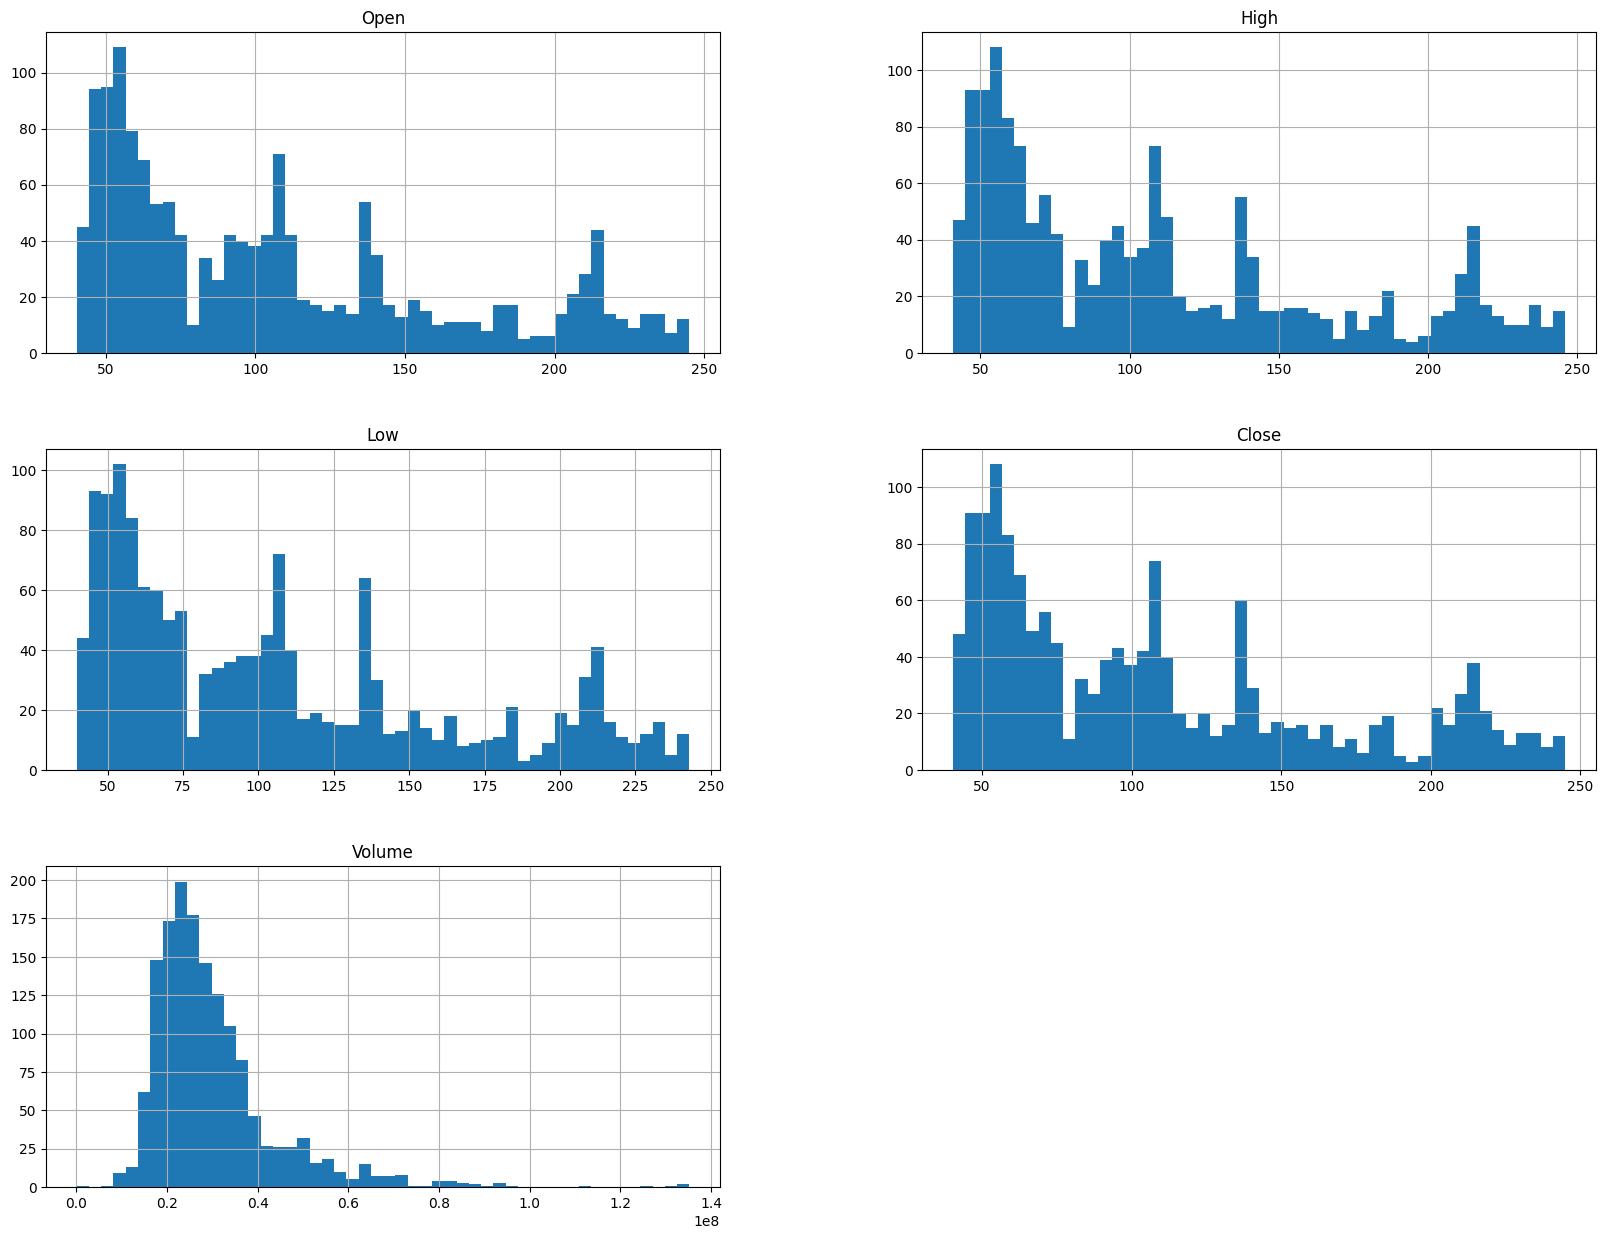

In [329]:
# plot the data
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [330]:
# Convert the 'Date' column in the DataFrame df to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index of df
df.set_index('Date', inplace=True)

# new 'time_series' create 'Close' column 
time_series = df['Close'] 

In [331]:
# Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
test_stationarity(time_series)

Results of Dickey-Fuller Test:
Test Statistic                    1.737136
p-value                           0.998216
#Lags Used                       24.000000
Number of Observations Used    1486.000000
Critical Value (1%)              -3.434758
Critical Value (5%)              -2.863487
Critical Value (10%)             -2.567807
dtype: float64


The Dickey_Fuller test results show that the time series is not stationary, as the p-value is greater than 0.05

Also the Test Statistic is greater thanthe Critical Value 

Test Statistic              =   1.737136 

Critical Value (1%)         =   -3.434758 

Critical Value (5%)         =   -2.863487

Critical Value (10%)        =   -2.567807


Will use differencing to stabalise the data prior to runing Arima etc.

In [332]:
# Differencing the time_series to ensure the data is stationary prior to modelling
diff_time_series = time_series.diff().dropna()

# Run test again
test_stationarity(diff_time_series)

Results of Dickey-Fuller Test:
Test Statistic                -1.003833e+01
p-value                        1.519594e-17
#Lags Used                     2.400000e+01
Number of Observations Used    1.485000e+03
Critical Value (1%)           -3.434761e+00
Critical Value (5%)           -2.863488e+00
Critical Value (10%)          -2.567807e+00
dtype: float64


Text(0.5, 1.0, 'Partial Autocorrelation Function')

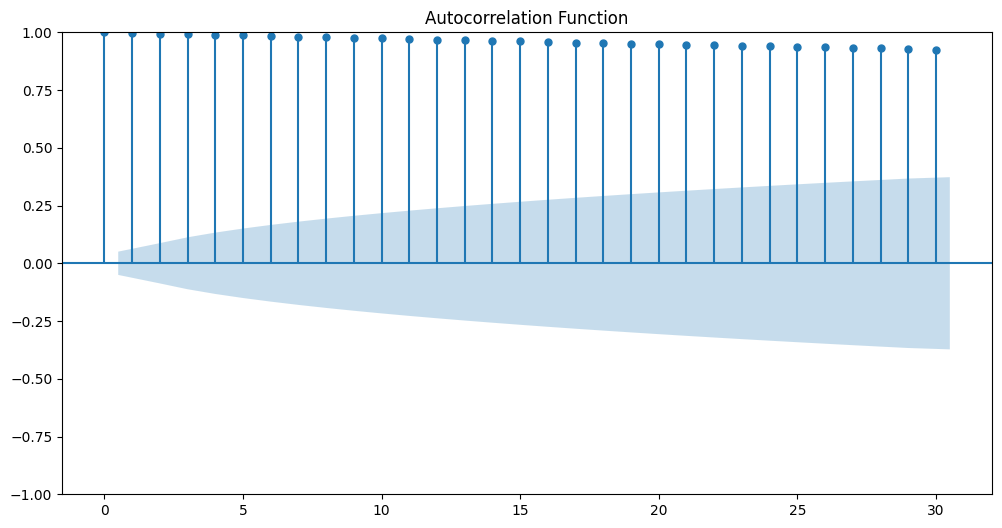

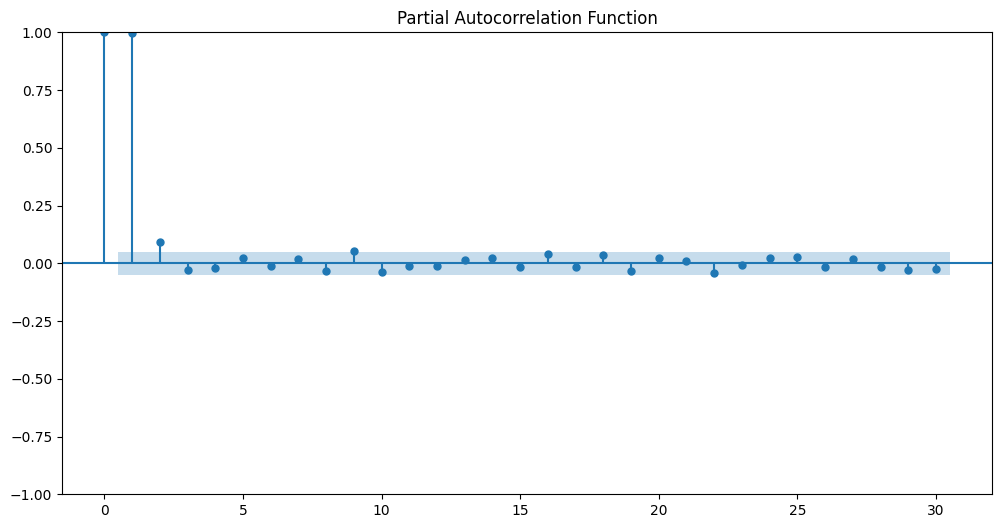

In [333]:
# Plot ACF prior to fitting ARIMA model
plt.figure(figsize=(12,6))
plot_acf(df['Close'], ax=plt.gca(), lags=30)
plt.title('Autocorrelation Function')

# Plot PACF
plt.figure(figsize=(12,6))
plot_pacf(df['Close'], ax=plt.gca(), lags=30)
plt.title('Partial Autocorrelation Function')

Text(0.5, 1.0, 'RSS: 9421.2645')

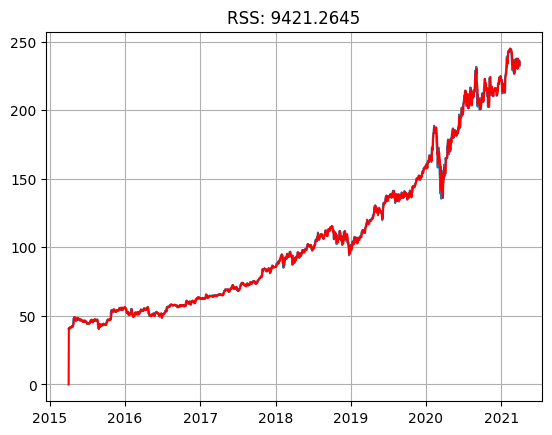

In [334]:
# Fitting the Arima model to 'Close'
model = ARIMA(df['Close'], order=(5,1,0))
results_ARIMA = model.fit()
plt.plot(df['Close'])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.grid(True)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df['Close'])**2))

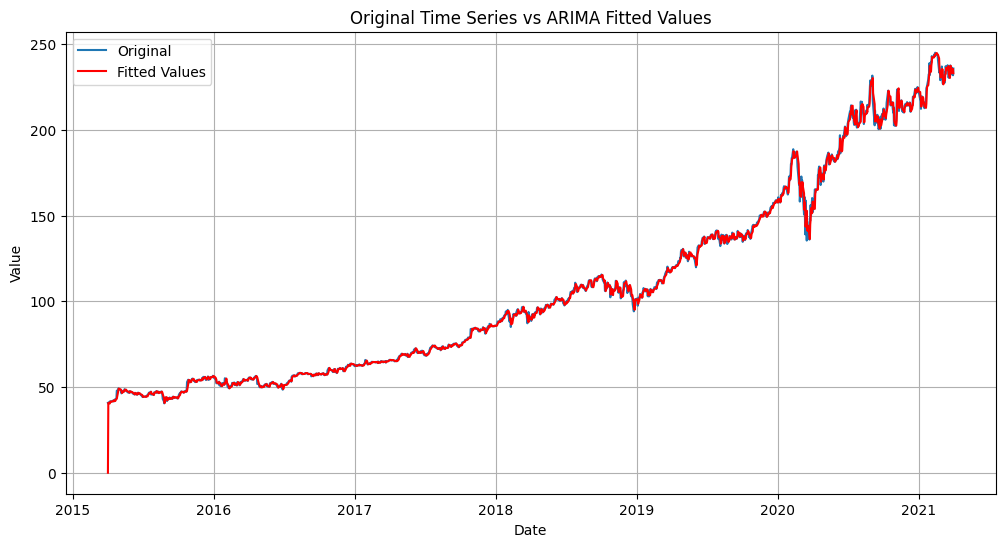

In [335]:
# Plot the original time series data with a label 'Original'
plt.figure(figsize=(12,6))
plt.plot(time_series, label='Original')

# Plot the fitted values from the ARIMA model in red with a label 'Fitted Values'
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values')


plt.title('Original Time Series vs ARIMA Fitted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [336]:
# Initialize an empty list to store the AIC values and corresponding p, d, q values
aicVals = []

# Loop p, d, and q for the ARIMA model
for p in range(5):
    for d in range(5):
        for q in range(5):
            try:
                # Fit an ARIMA model in order (p, d, q) 
                # Calculate the AIC of the fitted model
                aic = sm.ARIMA(df["Close"], order=(p,d,q)).fit().aic
                
                # Append the AIC and corresponding p, d, q values to the list
                aicVals.append([aic, p, d, q])
            except np.linalg.LinAlgError:
                # If the ARIMA model cannot be fitted due to a Linear Algebra error, skip this combination of p, d, q
                pass

# Sort p, d, q values in ascending order of AIC
aicVals.sort()

# Print the 5 models with the lowest AIC values
for val in aicVals[:5]:
    print(val)


[6713.195149071718, 3, 2, 3]
[6714.699285779436, 3, 1, 2]
[6714.771087954066, 4, 2, 4]
[6714.892088849241, 2, 2, 4]
[6715.2752179125, 4, 2, 3]


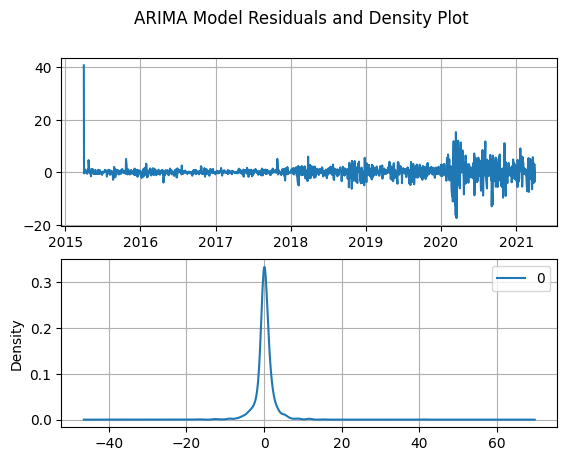

                 0
count  1511.000000
mean      0.183996
std       2.491058
min     -17.401024
25%      -0.465387
50%       0.114328
75%       0.909683
max      40.720000


In [337]:
# Extracting the residuals from the ARIMA model
residuals = pd.DataFrame(results_ARIMA.resid)

# Creating 2 plots one for the residuals plot and one for the density plot
fig, axs = plt.subplots(2)
fig.suptitle('ARIMA Model Residuals and Density Plot')

# Plot the residuals in the first subplot and add a grid
axs[0].plot(residuals)
axs[0].grid(True)

# Plot a Kernel Density Estimate (KDE) of the residuals in second plot
residuals.plot(kind='kde', ax=axs[1])
axs[1].grid(True)
plt.show()

# Print the residuals
print(residuals.describe())

In [338]:
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


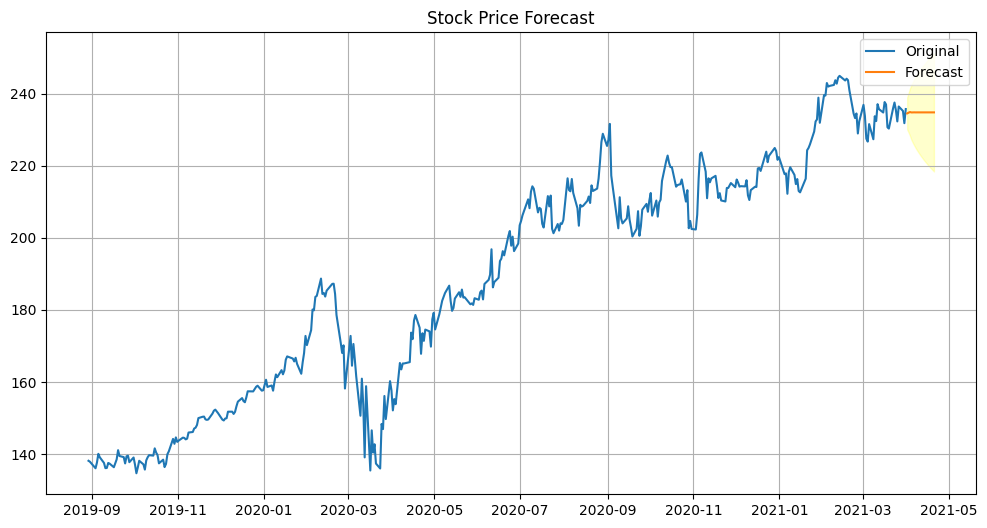

In [339]:
# Forecasting
forecast_steps = 20 #Steps forward to forecast
forecast_results = results_ARIMA.get_forecast(steps=forecast_steps)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Adjusting the date index for the forecast plot
last_date = time_series.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1)[1:] #-day1

# Plotting the Forecast
plt.figure(figsize=(12,6))
plt.plot(time_series[-400:], label='Original')  # last 400 data points of the original time series
plt.plot(forecast_index, forecast, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='yellow', alpha=0.2)
plt.legend()
plt.title('Stock Price Forecast')
plt.grid(True)
plt.show()

In [340]:
# Calculate forecast errors
true_values = df['Close'][-forecast_steps:] 
mse = mean_squared_error(true_values, forecast)
mae = mean_absolute_error(true_values, forecast)
rmse = math.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 2.5931507266043625
Mean Squared Error: 10.986465341074465
Root Mean Squared Error: 3.314583735716216


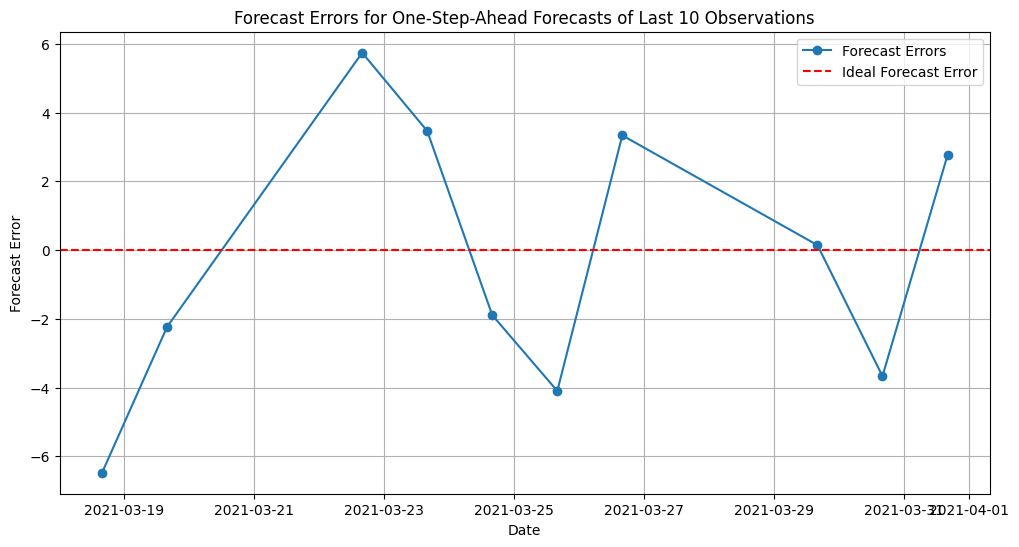

Date
2021-03-18 16:00:00   -6.475138
2021-03-19 16:00:00   -2.232705
2021-03-22 16:00:00    5.741149
2021-03-23 16:00:00    3.463889
2021-03-24 16:00:00   -1.891114
2021-03-25 16:00:00   -4.096964
2021-03-26 16:00:00    3.337111
2021-03-29 16:00:00    0.144043
2021-03-30 16:00:00   -3.665663
2021-03-31 16:00:00    2.757375
dtype: float64


In [341]:
# One-step-ahead forecasts of the last 10 observations
one_step_forecast = results_ARIMA.get_prediction(start=-10)

# Get the predicted means and the confidence intervals
predicted_mean = one_step_forecast.predicted_mean
# Calculate the forecast errors
forecast_errors = time_series[-10:] - predicted_mean

# Plotting the Forecast Errors
plt.figure(figsize=(12,6))
plt.plot(forecast_errors, label='Forecast Errors', marker='o')

# Plot a horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', label='Ideal Forecast Error')

# Plot the error bounds
plt.title('Forecast Errors for One-Step-Ahead Forecasts of Last 10 Observations')
plt.xlabel('Date')
plt.ylabel('Forecast Error')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecast errors
print(forecast_errors)

In [342]:
# Plotting interactive time series plot time
# peaks and troughs in 2020 intrigued me to investigate further
# Oil Uncertainty and COVID-19
trace = go.Scatter(
    x = diff_time_series.index,
    y = diff_time_series,
    mode = 'lines',
    name = 'diff_time_series'
)

data = [trace]

# Create a layout
layout = go.Layout(
    title='Time Series Plot',
    xaxis=dict(
        title='Date'
    ),
    yaxis=dict(
        title='Value'
    )
)

# Create a Figure and plot it
fig = go.Figure(data=data, layout=layout)
fig.show()

Text(0.5, 1.0, 'Partial Autocorrelation Function')

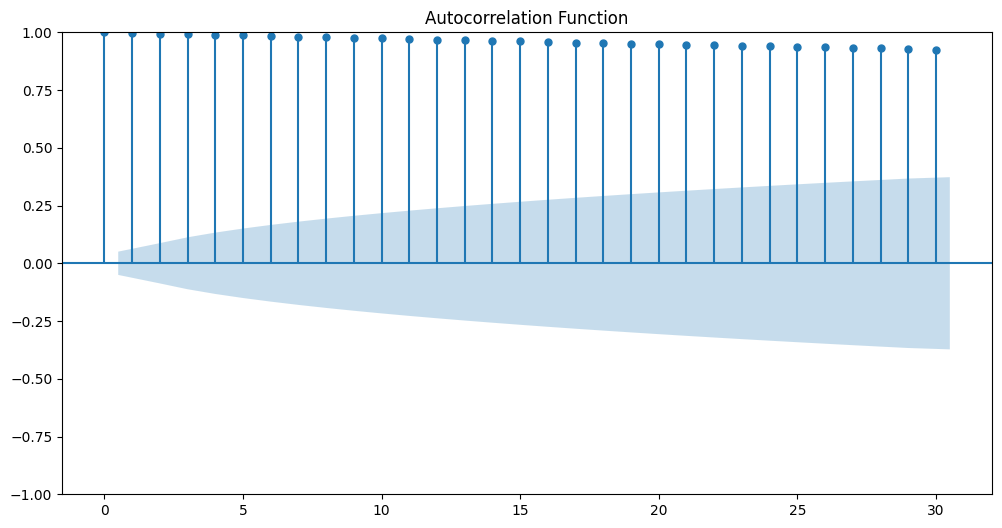

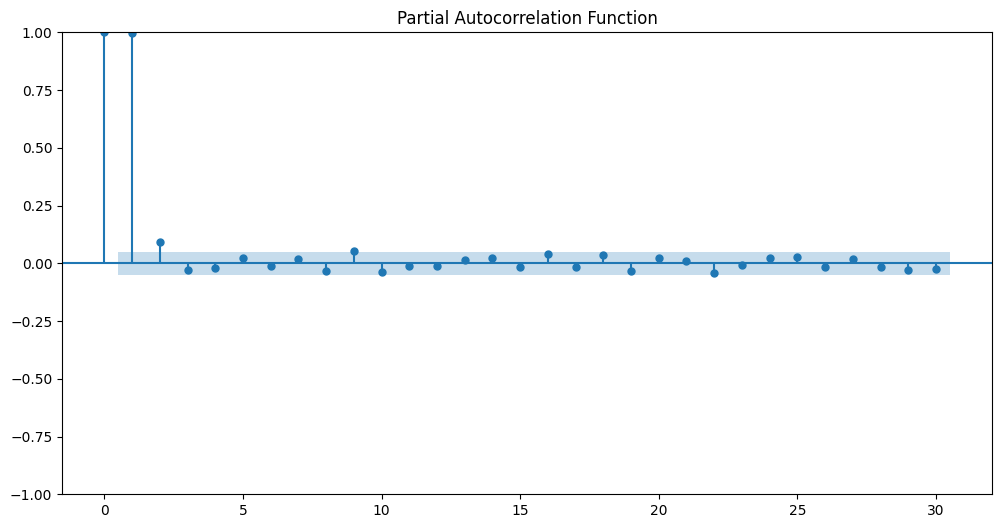

In [343]:
# Plot ACF
plt.figure(figsize=(12,6))
plot_acf(df['Close'], ax=plt.gca(), lags=30)
plt.title('Autocorrelation Function')

# Plot PACF
plt.figure(figsize=(12,6))
plot_pacf(df['Close'], ax=plt.gca(), lags=30)
plt.title('Partial Autocorrelation Function')

<Figure size 1200x600 with 0 Axes>

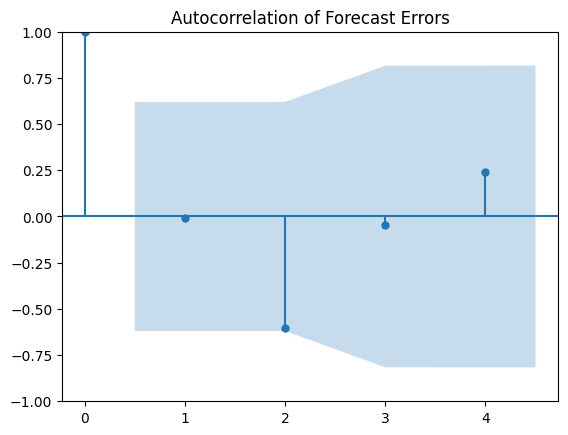

<Figure size 1200x600 with 0 Axes>

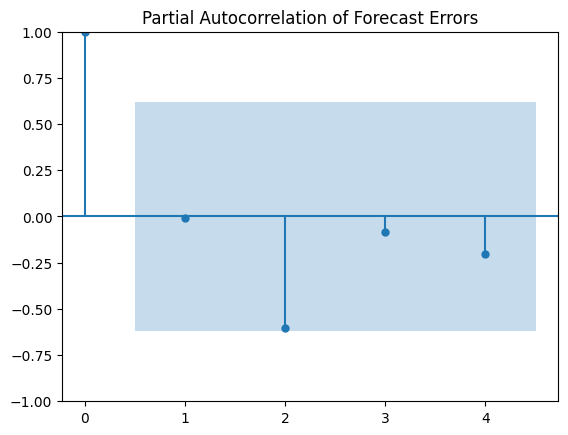

In [344]:
# Calculate and plot the Autocorrelation
plt.figure(figsize=(12,6))
plot_acf(forecast_errors, lags=min(10, len(forecast_errors)//2 - 1), title='Autocorrelation of Forecast Errors')
plt.show()

# Calculate and plot the Partial Autocorrelation
plt.figure(figsize=(12,6))
plot_pacf(forecast_errors, lags=min(10, len(forecast_errors)//2 - 1), title='Partial Autocorrelation of Forecast Errors')
plt.show()